In [134]:
from torch import set_grad_enabled, clamp, matmul, Tensor, sum,\
ones, randn, empty, max, exp, addmm, log, zeros, manual_seed, stack, flatten, mean, var
from torch.nn.init import normal_
from random import uniform
from math import pi, sqrt
import csv
import math
import matplotlib.pyplot as plt
import random
#%matplotlib notebook

### _I - Setting up_

In [40]:
# Turn off autograd
set_grad_enabled(False)

In [41]:
# Generates a data point sampled uniformly in [0,1]
# If the data is inside the disk centered at (0.5,0.5) of radius 1/2*pi, its label must be 1, else 0
def gen_point():
    center_x, center_y = 0.5, 0.5
    R = 1/sqrt(2*pi)
    rand_x, rand_y = uniform(0, 1), uniform(0, 1)
    label = 0
    if (rand_x - center_x) ** 2 + (rand_y - center_y) ** 2 <= R ** 2: #inside
        label = 1
    return [rand_x, rand_y], label

# Generates N points
def gen_points(N):
    pts = []
    labels = []
    for _ in range(N):
        pt, label = gen_point()
        pts.append(pt)
        labels.append(label)
    return pts, labels


In [42]:
# One-hot encodes y
def convert_to_one_hot(y):
    y_onehot = empty(y.size(0), 2) #2 because boolean one hot
    y_onehot.zero_()
    y_onehot[range(y.size(0)), y.long()] = 1
    return Tensor(y_onehot)

In [43]:
# One-hot decodes y
def decode_one_hot(y_onehot):
    y = empty(y_onehot.size(0))
    y = Tensor([0. if x[0]==1 else 1. for x in y_onehot])
    return y

<Figure size 720x576 with 0 Axes>

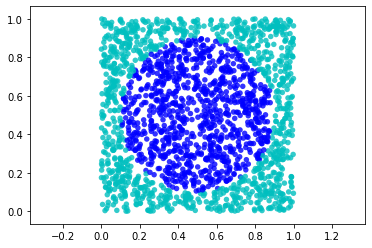

In [44]:
# Generate 1k samples of training data + 1k samples of testing data
all_points, all_labels = gen_points(2000)

# Plot the data
plt.figure(figsize=(10,8))
fig, ax = plt.subplots()
plt.axis('equal')
for p,r in zip(all_points, all_labels):
    ax.scatter(p[0], p[1], alpha=0.8, c='b' if r else 'c', edgecolors='none', s=30)

In [45]:
# Convert to tensors
all_points = Tensor(all_points)               # points = datapoint (x and y position)
all_labels = Tensor(all_labels)               # labels = 0 if the point is inside the disk, 1 if outside
all_targets = convert_to_one_hot(all_labels)  # targets = one hot encodings of the labels

# Split the dataset
train_pts, test_pts = all_points[:1000], all_points[1000:]
train_labels, test_labels = all_labels[:1000], all_labels[1000:]
train_targets, test_targets = all_targets[:1000], all_targets[1000:]

In [46]:
# Normalize the datasets
mean,std = train_pts.mean(), train_pts.std()
train_pts.sub_(mean).div_(std)
test_pts.sub_(mean).div_(std)

tensor([[-0.2690,  1.5684],
        [ 1.2187,  0.7741],
        [ 0.5526, -0.0167],
        ...,
        [ 1.0286,  1.6036],
        [ 1.6981,  0.6131],
        [ 1.3207, -1.1177]])

### _II - Defining network structures_

In [47]:
# Interface
class Module (object):
    def __init__(self):
        self.x = None           # The input to the current module
        self.prev_grad = None   # Gradient at the output of this module
    
    # Forward-pass method
    def forward (self, x):
        raise NotImplementedError
        
    # Backward propagation method
    def backward (self, prev_grad):
        raise NotImplementedError
        
    # Update method
    def step(self, lr, weight_decay):
        raise NotImplementedError
        
    def get_weights(self):
        raise NotImplementedError

In [111]:
# Fully connected layer
class Linear(Module):
    def __init__(self, in_dim, out_dim, method = 'random', seed = 0):
        super().__init__()
        
        # Fix the seed
        manual_seed(seed)
        
        # Scale with 0.2 not to have inf values and losses  
        if method == 'random':
            self.w = randn(in_dim, out_dim) * 0.2 # Random weights from normal dist
            self.b = randn(1, out_dim) * 0.2      # Random bias from normal dist

        elif method == 'he':
            self.w = randn(in_dim, out_dim)*sqrt(2/in_dim) * 0.2
            self.b = randn(1, out_dim) * 0.2

        elif method == 'xavier':
            self.w = randn(in_dim, out_dim)*sqrt(1/in_dim) * 0.1
            self.b = randn(1, out_dim) * 0.1

        elif method == 'zeros':
            self.w = zeros((in_dim, out_dim))
            self.b = zeros((1, out_dim))

        else:
            raise NotImplementedError("Initialization method not implemented")
        
    def forward(self, x):
        self.x = x
        return addmm(self.b, x, self.w)        # Without an activation function
    
    def backward(self, prev_grad): # add wd as parameter in all the backward
        self.prev_grad = prev_grad             # Cache the grad at the output for weight update.      
        current_grad = (prev_grad @ self.w.t()) #.add_(wd, self.w)   
        return current_grad                                          
        
    def step(self, lr, weight_decay):
        self.w -= lr * (self.x.t() @ self.prev_grad) - lr * (weight_decay * self.w) # Multiply the grad at output with dy/dw to update the weights
        self.b -= lr * (self.prev_grad.sum(dim=0))      # dy/db = 1. then dL / db = dy, which is the grad at the output
    
    def get_weights(self):
        return self.w

In [151]:
# Sequential structure to combine several modules
class Sequential(Module):
    def __init__(self, module_list):
        self.module_list = module_list
        
    def forward(self, x, mode = 'train'):
        out = self.module_list[0].forward(x)
        for module in self.module_list[1:]:
            out = module.forward(out)
        return out
    
    def backward(self, gradwrtoutput):
        for model in self.module_list[::-1]:
            gradwrtoutput = model.backward(gradwrtoutput)
            
    def step(self, lr, weight_decay = 0):
        for module in self.module_list:
            module.step(lr, weight_decay)
            
    def get_weights(self):
        weights = []
        for module in self.module_list:
            m_weight = module.get_weights()
            if (m_weight == None):
                continue
            weights += [module.get_weights()]
        return weights

In [154]:
# Batch Normalization layer
class BatchNorm(Module):
    
    def __init__(self, dim):
        self.momentum = 0.9
        self.eps = 1e-5
        self.gamma = ones(dim) # scale param
        self.beta = zeros(dim) # shift param
        self.mean = zeros(dim) # averaged mean
        self.var = zeros(dim) # averaged variance
        super().__init__()
        
    def forward(self, x, mode='train'):
        self.x = x
        if mode == 'train':
            self.mean = self.momentum * self.mean + (1 - self.momentum) * mean(x)
            self.var = self.momentum * self.var + (1 - self.momentum) * var(x) 
            self.norm = (x - mean(x)) / sqrt(var(x) + self.eps) # normalized value
            return self.gamma * self.norm + self.beta # normalized, scaled and shifted value
        elif mode == 'test':
            return self.gamma * (x - self.mean) / sqrt(self.var + self.eps) + self.beta
            
    
    def backward(self, prev_grad):
        #dgamma = sum(prev_grad * norm)
        #dbeta = sum(prev_grad)
        dnorm = prev_grad * self.gamma # scaled value
        return 1/prev_grad.size(0) / std * (prev_grad.size(0) * dnorm - sum(dnorm) - 
                                            self.norm * sum(dnorm * self.norm))    
    
    def step(self, lr, weight_decay):
        pass
    
    def get_weights(self):
        pass

### _III - Defining activation functions_

In [51]:
# ReLu activation function
class ReLU(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return x.clamp(min = 0)       # Negative values -> 0, positive values stay the same (relu = max(0,x))
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    # Cache the gradient at the output 
        curr_grad = prev_grad.clone() # Copy it for returning the new gradient
        curr_grad[self.x < 0] = 0     # Relu = max(0,x), grad_relu = 0 if x <= 0 else 1
        return curr_grad
    
    def step(self, lr, weight_decay):
        pass    
    
    def get_weights(self):
        pass

In [101]:
# Leaky ReLu activation function
class LeakyReLU(Module):
    
    def __init__(self, slope = 0.01):
        self.slope = slope
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return max(self.slope * x, x)
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    # Cache the gradient at the output 
        curr_grad = prev_grad.clone()
        curr_grad[self.x < 0] *= self.slope
        return curr_grad
    
    def step(self, lr, weight_decay):
        pass    
    
    def get_weights(self):
        pass

In [119]:
# Tanh activation function
class Tanh(Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.x = x
        return (exp(x) - exp(-x)) / (exp(x) + exp(-x))                         # Tanh function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                                             # Cache the gradient at the output
        tanh_x = (exp(self.x) - exp(-self.x)) / (exp(self.x) + exp(-self.x))   # Tanh of x
        curr_grad = prev_grad * (1 - (tanh_x)**2)                              # Current gradient 
        return curr_grad
    
    def step(self, lr, weight_decay):
        pass

    def get_weights(self):
        pass

In [54]:
# Sigmoid activation function
class Sigmoid(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return 1 / (1 + exp(-x))                              # Sigmoid function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                            # Cache the gradient at the output 
        sigmoid_x = 1 / (1 + exp(-self.x))                    # Sigmoid of x
        curr_grad = prev_grad * sigmoid_x * (1 - sigmoid_x)   # Current gradient
        return curr_grad

    def step(self, lr, weight_decay):
        pass
    
    def get_weights(self):
        pass

### _IV - Defining  cost functions_

In [55]:
# Computes the Mean Squared Error & Gradient at output
def mse(pred, target):
    return sum((pred - target)**2),  2* (pred-target)

In [56]:
# Softmax function stabilized by taking x = x-max(x)
def softmax(x):
    return exp(x-max(x))/sum(exp(x-max(x)))

# Computes the Cross Entropy Loss
def crossEntropyLoss(pred, target):
    return -sum(target*softmax(pred).log()), pred-target

### _V - Training and measuring performance_

In [155]:
# Instanciates a model with respect to the model id given as input to the function
def model_selector(mid, seed = 0):
    
    # ReLU activation
    if mid == 0:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), ReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), ReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), ReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3), ReLU()])
        return model
    
    # ReLU & Sigmoid activations
    elif mid == 1:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), ReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), ReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), ReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3), Sigmoid()])    
        return model
    
    # ReLU & Tanh activations
    elif mid == 2:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), ReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), ReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), ReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3), Tanh()])             
        return model     
    
    # ReLU & Softmax activations (included in the cross entropy)
    elif mid == 3:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), ReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), ReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), ReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3)])             
        return model  
    
    # Leaky ReLU activation
    elif mid == 4:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), LeakyReLU(),#slope = 0.00005),
                            Linear(25,25, method = 'random', seed = seed + 1), LeakyReLU(),#slope = 0.00005), 
                            Linear(25,25, method = 'random', seed = seed + 2), LeakyReLU(),#slope = 0.00005), 
                            Linear(25,2, method = 'random', seed = seed + 3), LeakyReLU()])#slope = 0.00005)])             
        return model  
    
    # Leaky ReLU & Sigmoid activations
    elif mid == 5:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), LeakyReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), LeakyReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), LeakyReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3), Sigmoid()])             
        return model  
    
    # Leaky ReLU & Tanh activations
    elif mid == 6:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), LeakyReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), LeakyReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), LeakyReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3), Tanh()])             
        return model

    # Leaky ReLU & Softmax activations (included in the cross entropy)
    elif mid == 7:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), LeakyReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), LeakyReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), LeakyReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3)])             
        return model  
    
    # Tanh activations (included in the cross entropy)
    elif mid == 8:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), Tanh(),
                            Linear(25,25, method = 'random', seed = seed + 1), Tanh(), 
                            Linear(25,25, method = 'random', seed = seed + 2), Tanh(), 
                            Linear(25,2, method = 'random', seed = seed + 3), Tanh()])          
        return model
    
    # ReLU & Sigmoid activations with BatchNorm
    elif mid == 9:
        model = Sequential([Linear(2,25, method = 'random', seed = seed), BatchNorm(25), ReLU(),
                            Linear(25,25, method = 'random', seed = seed + 1), BatchNorm(25), ReLU(), 
                            Linear(25,25, method = 'random', seed = seed + 2), BatchNorm(25), ReLU(), 
                            Linear(25,2, method = 'random', seed = seed + 3), BatchNorm(2), Sigmoid()])
        return model

In [58]:
# Batch generator
def data_generator(pts, targets, labels, batch_size):
    data_len = pts.size(0)
    i = 0
    while i < data_len:
        j = i + batch_size if i +batch_size < data_len else data_len
        yield pts[i:j], targets[i:j], labels[i:j]
        i = j

In [148]:
# Trains the model over n epochs with mini batch processing
def train(model, train_pts, train_targets, n_epoch, lr0, test_pts = [], test_targets = [], 
          train_history = False, test_history = False, weight_decay = 0, lr_decay_type='exponential', lr_decay = 0, 
          criterion = 'MSE', batch_size = 1000, optimizer = 'MiniBatch'):
    
    # History
    model_history = dict()
    
    # Loss histories
    train_losses = []
    test_losses = []
    
    # Accuracy histories
    train_accs = []
    test_accs = []
    
    # Labels (needed if the accuracies are computed)
    train_labels = []
    test_labels = []
    if (train_history):
        train_labels = decode_one_hot(train_targets)
    if (test_history):
        test_labels = decode_one_hot(test_targets)
    
    # Train for n epochs
    for e in range(n_epoch):
        epoch_train_loss = 0 
        
        # Learning rate decay
        if lr_decay_type == 'exponential':
            lr = lr0 * math.exp( -lr_decay * n_epoch)
        if lr_decay_type == 'time-based':
            lr = lr0 * (1. / (1. + lr_decay * n_epoch))
        if lr_decay_type == 'step-decay':
            lr = lr0 * math.pow(0.5,math.floor((1+n_epoch)/10))

        # Generate batches
        generator = data_generator(train_pts, train_targets, train_labels, batch_size)
        
        # For each batch
        for i, (t_pts, ts, t_labels) in enumerate(generator):
            
            # Forward pass
            train_pred = model.forward(t_pts)

            # Compute loss
            if(criterion == 'MSE'):
                train_loss, grad_at_output = mse(train_pred, ts.view(-1, 2))
            elif(criterion == 'CROSSENTROPY'):
                train_loss, grad_at_output = crossEntropyLoss(train_pred, ts.view(-1, 2))
            else:
                raise NotImplementedError("Criterion not implemented")
                        
            # Weight decay
            weights = model.get_weights()
            l2_penality = 0
            for w in weights:
                l2_penality += (w**2).sum()
            train_loss += weight_decay * l2_penality/2
            
            # Backward prop
            model.backward(grad_at_output)
            model.step(lr, weight_decay = weight_decay)
            epoch_train_loss += train_loss.item()
            
        # If we want to keep histories about training loss & accuracy               
        if (train_history):
                train_losses.append(epoch_train_loss)
                train_accs.append(compute_acc(model, t_pts, t_labels, train_pred)) 
        
        # If we want to keep histories about testing loss & accuracy
        if (test_history):
            
            # Forward pass
            test_pred = model.forward(test_pts, mode = 'test')
            
            # Compute loss
            if(criterion=='MSE'):
                test_loss, _ = mse(test_pred, test_targets.view(-1, 2))
            elif(criterion=='CROSSENTROPY'):
                test_loss, _ = crossEntropyLoss(test_pred, test_targets.view(-1, 2))
            else:
                raise NotImplementedError("Criterion not implemented")
            
            #test_loss += wd * (w**2).sum()/2
            test_losses.append(test_loss.item())
            test_accs.append(compute_acc(model, test_pts, test_labels, test_pred))
        
    # If we want to keep histories about training
    if (train_history):
        model_history['train_loss'] = train_losses
        model_history['test_loss'] = test_losses
    
    # If we want to keep histories about testing
    if (test_history):
        model_history['train_accuracy'] = train_accs
        model_history['test_accuracy'] = test_accs
        
    return model_history

In [60]:
# Computes accuracy
def compute_acc(model, pts, labels, pred):
    n_samples = pts.size(0)
    _, indices = max(pred.view(-1,2), 1)
    accuracy = (sum(indices.view(-1,1) == labels.view(-1, 1)) / float(n_samples) * 100).item()
    return accuracy

In [61]:
# Test the performance of the relu only model with tuned hyper parameters

model_relu = model_selector(0)
history_relu = train(model_relu, train_pts, train_targets, 250, 0.00007, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, weight_decay = 0, criterion = 'MSE')
acc_relu = compute_acc(model_relu, test_pts, test_labels, model_relu.forward(test_pts))
print(acc_relu)

96.69999694824219


In [70]:
# Test the performance of the relu & sigmoid model with tuned hyper parameters 

model_relu_sig = model_selector(1)
history_relu_sig = train(model_relu_sig, train_pts, train_targets, 500, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                        train_history = True, test_history = True, weight_decay = 0, criterion = 'MSE')
acc_relu_sig = compute_acc(model_relu_sig, test_pts, test_labels, model_relu_sig.forward(test_pts))
print(acc_relu_sig)

98.79999542236328


In [63]:
# Test the performance of the relu & tanh model with tuned hyper parameters

model_relu_tanh = model_selector(2)
history_relu_tanh = train(model_relu_tanh, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'MSE')
acc_relu_tanh = compute_acc(model_tanh, test_pts, test_labels, model_relu_tanh.forward(test_pts))
print(acc_relu_tanh)

95.9000015258789


In [64]:
# Test the performance of the relu & softmax model with tuned hyper parameters

model_relu_soft = model_selector(3)
history_relu_soft = train(model_relu_soft, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'CROSSENTROPY')
acc_relu_soft = compute_acc(model_relu_soft, test_pts, test_labels, model_relu_soft.forward(test_pts))
print(acc_soft)

77.4000015258789


In [113]:
# Test the performance of the leaky relu model with tuned hyper parameters

model_leaky = model_selector(4)
history_leaky = train(model_leaky, train_pts, train_targets, 250, 0.00009, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'MSE')
acc_leaky = compute_acc(model_leaky, test_pts, test_labels, model_leaky.forward(test_pts))
print(acc_leaky)

94.5999984741211


In [114]:
# Test the performance of the leaky relu & sigmoid model

model_leaky_sig = model_selector(5)
history_leaky_sig = train(model_leaky_sig, train_pts, train_targets, 500, 0.0005, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'MSE')
acc_leaky_sig = compute_acc(model_leaky_sig, test_pts, test_labels, model_leaky_sig.forward(test_pts))
print(acc_leaky_sig)

96.30000305175781


In [126]:
# Test the performance of the leaky relu & tanh model

model_leaky_tanh = model_selector(6)
history_leaky_tanh = train(model_leaky_tanh, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'MSE')
acc_leaky_tanh = compute_acc(model_leaky_tanh, test_pts, test_labels, model_leaky_tanh.forward(test_pts))
print(acc_leaky_tanh)

94.80000305175781


In [116]:
# Test the performance of the leaky relu & softmax model with tuned hyper parameters

model_leaky_soft = model_selector(7)
history_leaky_soft = train(model_leaky_soft, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'CROSSENTROPY')
acc_leaky_soft = compute_acc(model_leaky_soft, test_pts, test_labels, model_leaky_soft.forward(test_pts))
print(acc_leaky_soft)

96.9000015258789


In [121]:
# Test the performance of the tanh model with tuned hyper parameters

model_tanh = model_selector(8)
history_tanh = train(model_tanh, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'CROSSENTROPY')
acc_tanh = compute_acc(model_tanh, test_pts, test_labels, model_tanh.forward(test_pts))
print(acc_tanh)

92.5999984741211


In [157]:
# Test the performance of the reLu sig model with tuned hyper parameters and batchNorm layers

model_norm = model_selector(9)
history_norm = train(model_norm, train_pts, train_targets, 250, 0.0001, test_pts = test_pts, test_targets = test_targets, 
                     train_history = True, test_history = True, criterion = 'MSE')
acc_norm = compute_acc(model_norm, test_pts, test_labels, model_norm.forward(test_pts))
print(acc_norm)

73.5999984741211


In [993]:
def simple_plot(history, model_name, train_history = False, test_history = False):
    train_losses = history['train_loss']
    test_losses = history['test_loss']
    train_accs = history['train_accuracy']
    test_accs = history['test_accuracy']
    
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_losses, alpha = 0.5, color = 'b', linewidth = 2.0, label = model_name + " Training Loss")
            
    if (test_history):
        plt.plot(test_losses, alpha = 0.5, color = 'g', linewidth = 2.0, label = model_name + " Testing Loss")
            
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_accs, alpha = 0.5, color = 'b', linewidth = 2.0, label = model_name + " Training Loss")

    if (test_history):
        plt.plot(test_accs, alpha = 0.5, color = 'g', linewidth = 2.0, label = model_name + " Testing Loss")
            
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

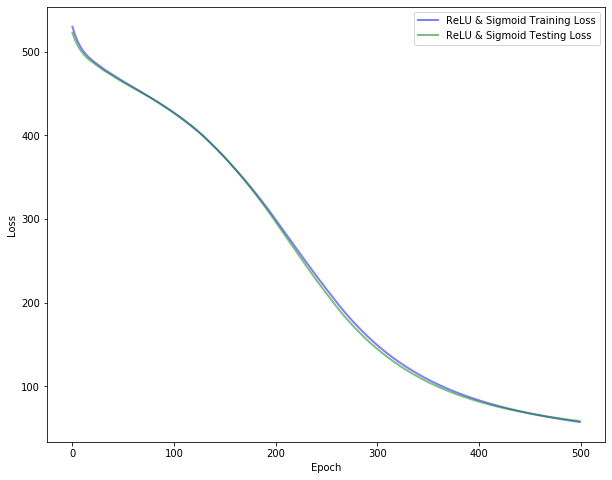

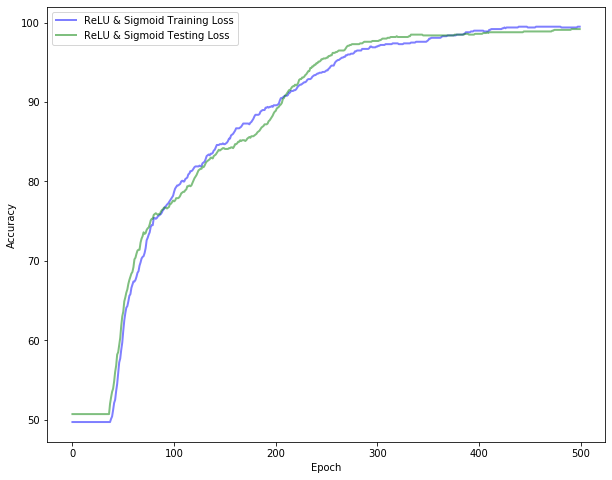

In [1214]:
#simple_plot(history_relu, 'ReLU', train_history = True, test_history = True)
simple_plot(history_relu_sig, 'ReLU & Sigmoid', train_history = True, test_history = True)
#simple_plot(history_relu_tanh, 'ReLU & Tanh', train_history = True, test_history = True)
#simple_plot(history_relu_soft, 'ReLU & Softmax', train_history = True, test_history = True)
#simple_plot(history_leaky, 'Leaky ReLU', train_history = True, test_history = True)
#simple_plot(history_leaky_sig, 'Leaky ReLU & Sigmoid', train_history = True, test_history = True)
#simple_plot(history_leaky_tanh, 'Leaky ReLU & Tanh', train_history = True, test_history = True)
#simple_plot(history_leaky_soft, 'Leaky ReLU & Softmax', train_history = True, test_history = True)
#simple_plot(history_tanh, 'Tanh', train_history = True, test_history = True)

### VI - Hyper-parameter tuning

In [1267]:
# Performs a k-fold cross validation
def cross_val_score(mid, train_pts, train_labels, train_targets, n_epoch, lr, wd, ld, ld_type, c, k_folds = 4, batch_size = 1000):
    len_train = train_pts.size(0)
    indices = [i for i in range(len_train)]
    random.seed(8)
    random.shuffle(indices)
    accs = []
    for k in range(k_folds):
        model = model_selector(mid)  # Init the same model
        
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        # Train the model with k-1 training fold
        history = train(model, train_pts[train_indices], train_targets[train_indices], n_epoch, lr,\
                        criterion = c, batch_size = batch_size, weight_decay = wd, lr_decay = ld,\
                        lr_decay_type = ld_type, train_history = True, test_history = True,\
                        test_pts = train_pts[val_indices], test_targets = train_targets[val_indices])
        
        # Compute the accuracy on 1 validation fold
        acc = compute_acc(model, train_pts[val_indices], train_labels[val_indices], model.forward(train_pts[val_indices])) 
        accs.append(acc)
        
    return Tensor(accs).mean(), history

In [1268]:
def grid_search():
    
    # Parameters
    mids = [0,1,2,3,4,5,6,7,8]
    lrs = [0.00005, 0.00007, 0.0001, 0.0005]
    epochs = [250, 500]
    weight_decays = [0, 0.0001, 0.001, 0.01]
    learning_decays = [0, 0.0001, 0.001, 0.01]
    learning_decay_types = ['exponential', 'time-based']
    criterions = ['MSE', 'CROSSENTROPY']
    
    # Prepare the csv file to export the histories
    csv_columns = ['mid','lr','epoch','wd','ld','ld_type','criterion','avg_acc',\
                   'train_loss', 'test_loss', 'train_accuracy', 'test_accuracy']
    csv_file = open("gridsearch.csv", "a")
    writer = csv.DictWriter(csv_file, fieldnames = csv_columns)    
    writer.writeheader() 
    csv_file.close()
    
    for mid in mids:
        for lr in lrs:
            for epoch in epochs:
                for wd in weight_decays:
                    for ld in learning_decays:
                        for ld_type in learning_decay_types:
                            for c in criterions:
                                
                                csv_file = open("gridsearch.csv", "a")
                                writer = csv.DictWriter(csv_file, fieldnames = csv_columns)  
                                
                                avg, history = cross_val_score(mid, train_pts, train_labels, train_targets, epoch, lr,\
                                                     wd, ld, ld_type, c)
                                print("MID = ", mid, "LR = ", lr,"#Epoch = ", epoch,"WD = ", wd, "LD = ", ld,\
                                      "LD_TYPE = ", ld_type, "Criterion = ", c, "AVG Acc = ", avg.item())
                                # Export the row to CSV
                                row = {}
                                row['mid'] = mid
                                row['lr'] = lr
                                row['epoch'] = epoch
                                row['wd'] = wd
                                row['ld'] = ld
                                row['ld_type'] = ld_type
                                row['criterion'] = c
                                row['avg_acc'] = avg.item()
                                row['train_loss'] = history['train_loss']
                                row['test_loss'] = history['test_loss']
                                row['train_accuracy'] = history['train_accuracy']
                                row['test_accuracy'] = history['test_accuracy']
                                writer.writerow(row)
                                csv_file.close()

In [1269]:
grid_search()

MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0 LD_TYPE =  exponential Criterion =  MSE AVG Acc =  97.69999694824219
MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0 LD_TYPE =  exponential Criterion =  CROSSENTROPY AVG Acc =  93.0
MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0 LD_TYPE =  time-based Criterion =  MSE AVG Acc =  97.69999694824219
MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0 LD_TYPE =  time-based Criterion =  CROSSENTROPY AVG Acc =  93.0
MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0.0001 LD_TYPE =  exponential Criterion =  MSE AVG Acc =  97.69999694824219
MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0.0001 LD_TYPE =  exponential Criterion =  CROSSENTROPY AVG Acc =  92.5999984741211
MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0.0001 LD_TYPE =  time-based Criterion =  MSE AVG Acc =  97.69999694824219
MID =  0 LR =  5e-05 #Epoch =  250 WD =  0 LD =  0.0001 LD_TYPE =  time-based Criterion =  CROSSENTROPY AVG Acc =  92.5999984741211
MID =  0 LR =  5

KeyboardInterrupt: 

### _VII - Plots_

In [416]:
# Grid search for the fifth model
lrs = [0.00001, 0.00003, 0.00005, 0.00007, 0.00009, 0.00011, 0.00013, 0.00015]
grid_search(4, lrs, criterion = 'MSE')

MID =  4 LR =  1e-05 #Epoch =  50 Avg Acc =  51.599998474121094
MID =  4 LR =  3e-05 #Epoch =  50 Avg Acc =  55.29999923706055
MID =  4 LR =  5e-05 #Epoch =  50 Avg Acc =  65.5
MID =  4 LR =  7e-05 #Epoch =  50 Avg Acc =  64.80000305175781
MID =  4 LR =  9e-05 #Epoch =  50 Avg Acc =  75.69999694824219
MID =  4 LR =  0.00011 #Epoch =  50 Avg Acc =  83.69999694824219
MID =  4 LR =  0.00013 #Epoch =  50 Avg Acc =  82.0
MID =  4 LR =  0.00015 #Epoch =  50 Avg Acc =  76.0999984741211
MID =  4 LR =  1e-05 #Epoch =  100 Avg Acc =  55.29999923706055
MID =  4 LR =  3e-05 #Epoch =  100 Avg Acc =  66.0999984741211
MID =  4 LR =  5e-05 #Epoch =  100 Avg Acc =  77.80000305175781
MID =  4 LR =  7e-05 #Epoch =  100 Avg Acc =  85.0
MID =  4 LR =  9e-05 #Epoch =  100 Avg Acc =  66.9000015258789
MID =  4 LR =  0.00011 #Epoch =  100 Avg Acc =  71.4000015258789
MID =  4 LR =  0.00013 #Epoch =  100 Avg Acc =  79.5
MID =  4 LR =  0.00015 #Epoch =  100 Avg Acc =  85.19999694824219
MID =  4 LR =  1e-05 #Epoch

In [828]:
def generate_histories():

    # Parameters
    n_training = 10
    mids = [0,1,2,3,4]
    lrs = [0.00007,0.005,0.0001,0.0001,0.00009]
    criterions = ['MSE','MSE','MSE','CROSSENTROPY','MSE']
    performances = ['train_loss','test_loss','train_accuracy','test_accuracy']

    histories_mean = {}
    histories_std = {}
    histories = {}

    # Generate the histories for each model
    for m in mids :
        histories[m] = {'train_loss':[], 'test_loss':[], 'train_accuracy':[], 'test_accuracy':[]}
        histories_mean[m] = {'train_loss':[], 'test_loss':[], 'train_accuracy':[], 'test_accuracy':[]}
        histories_std[m] = {'train_loss':[], 'test_loss':[], 'train_accuracy':[], 'test_accuracy':[]}

        for n in range(n_training):
            model = model_selector(m, seed = n)
            history_model = train(model, train_pts, train_targets, 250, lrs[m],
                            test_pts = test_pts, test_targets = test_targets, train_history = True,
                            test_history = True, criterion = criterions[m])
            for p in performances :
                histories[m][p] += [history_model[p]]

        # Compute the mean and std for each performance
        for p in performances :
            histories_mean[m][p] = Tensor(histories[m][p]).mean(axis = 0)
            histories_std[m][p] = Tensor(histories[m][p]).std(axis = 0)
    
    res = {'means' : histories_mean, 'stds' : histories_std}
    return res

In [829]:
def plot_loss(histories, mid, model_name, train_history = False, test_history = False):
    train_mean_losses = histories['means'][mid]['train_loss']
    test_mean_losses = histories['means'][mid]['test_loss']
    train_std_losses = histories['stds'][mid]['train_loss']
    test_std_losses = histories['stds'][mid]['test_loss']
    
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_mean_losses, alpha = 0.5, color = 'b', linewidth = 2.0, label = model_name + " Training Loss")
        plt.fill_between(range(len(train_mean_losses)), train_mean_losses - train_std_losses,\
                      train_mean_losses + train_std_losses, color = 'b', alpha=0.2)
            
    if (test_history):
        plt.plot(test_mean_losses, alpha = 0.5, color = 'g', linewidth = 2.0, label = model_name + " Testing Loss")
        plt.fill_between(range(len(test_mean_losses)), test_mean_losses - test_std_losses,\
                      test_mean_losses + test_std_losses, color = 'g', alpha=0.2)
            
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [830]:
def plot_acc(histories, mid, model_name, train_history = False, test_history = False):
    train_mean_accs = histories['means'][mid]['train_accuracy']
    test_mean_accs = histories['means'][mid]['test_accuracy']
    train_std_accs = histories['stds'][mid]['train_accuracy']
    test_std_accs = histories['stds'][mid]['test_accuracy']
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_mean_accs, alpha = 0.5, color = 'c', linewidth = 2.0, label = model_name + " Training Accuracy")
        plt.fill_between(range(len(train_mean_accs)), train_mean_accs - train_std_accs,\
                      train_mean_accs + train_std_accs, color = 'c', alpha=0.2)
            
    if (test_history):
        plt.plot(test_mean_accs, alpha = 0.5, color = 'm', linewidth = 2.0, label = model_name + " Testing Accuracy")
        plt.fill_between(range(len(test_mean_accs)), test_mean_accs - test_std_accs,\
                      test_mean_accs + test_std_accs, color = 'm', alpha=0.2)
            
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [831]:
# Generate the histories
histories = generate_histories()

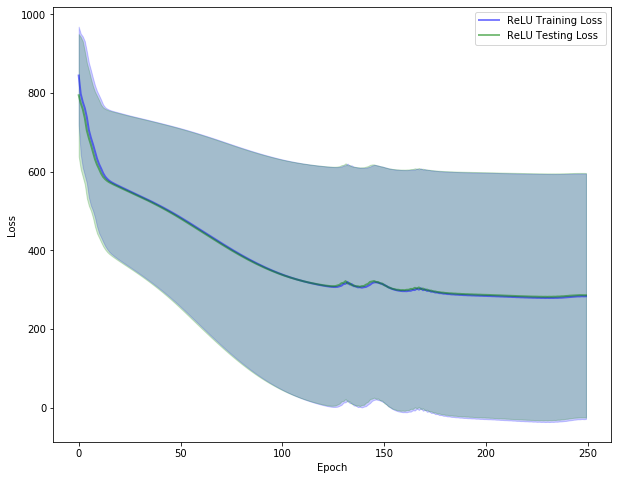

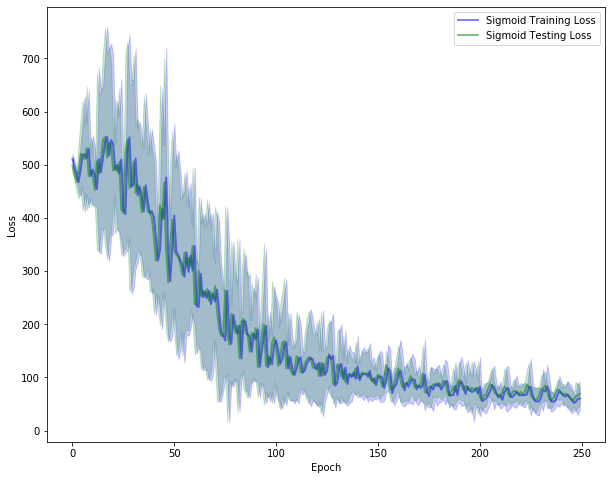

In [832]:
plot_loss(histories, 0, 'ReLU', train_history = True, test_history = True)
plot_loss(histories, 1, 'Sigmoid', train_history = True, test_history = True)

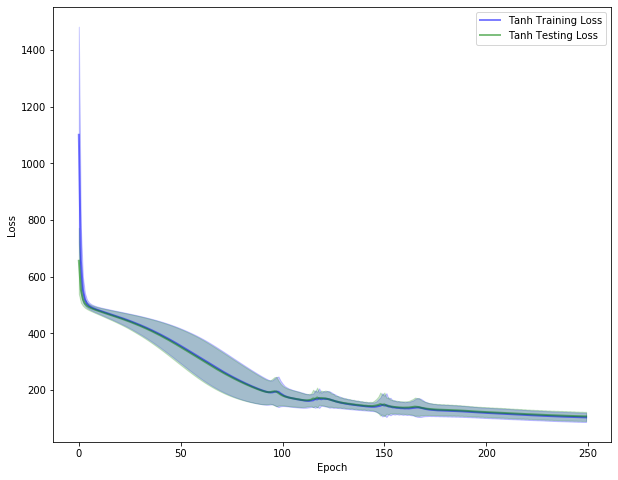

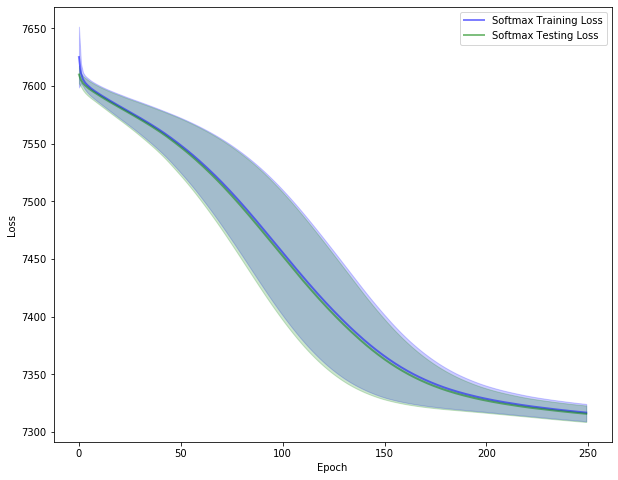

In [833]:
plot_loss(histories, 2, 'Tanh', train_history = True, test_history = True)
plot_loss(histories, 3, 'Softmax', train_history = True, test_history = True)

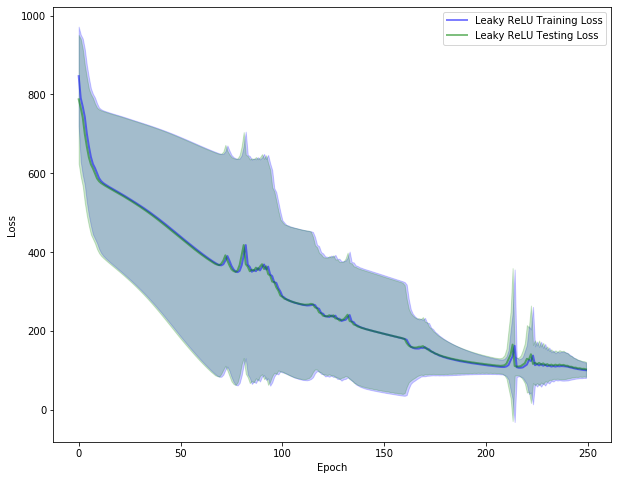

In [834]:
plot_loss(histories, 4, 'Leaky ReLU', train_history = True, test_history = True)

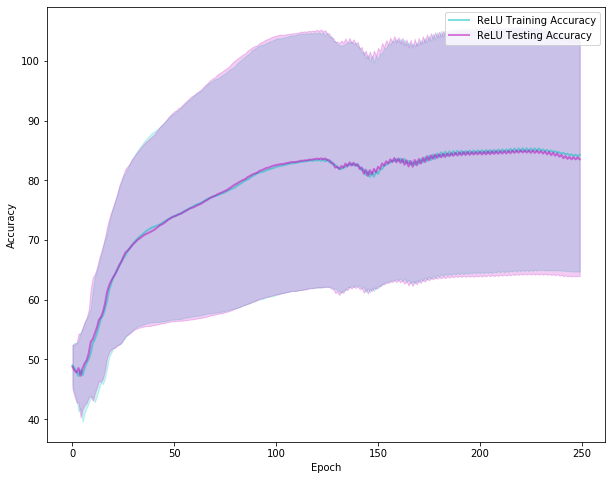

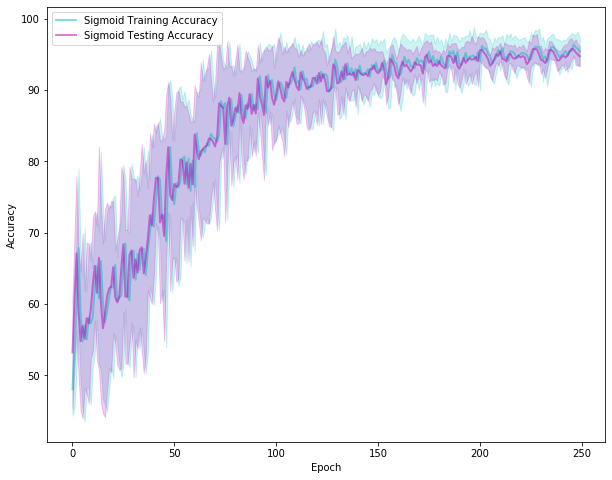

In [835]:
plot_acc(histories, 0, 'ReLU', train_history = True, test_history = True)
plot_acc(histories, 1, 'Sigmoid', train_history = True, test_history = True)

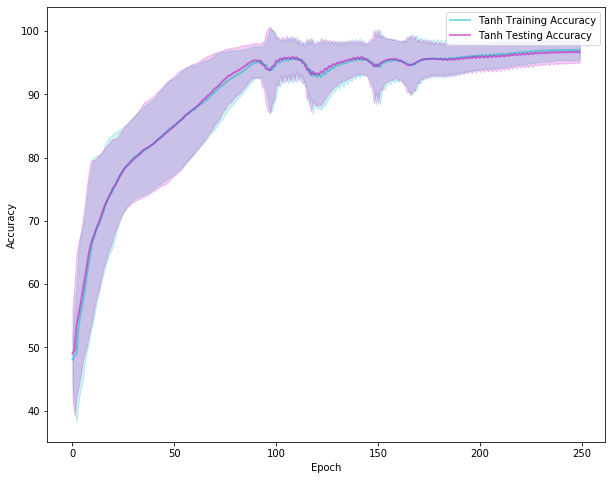

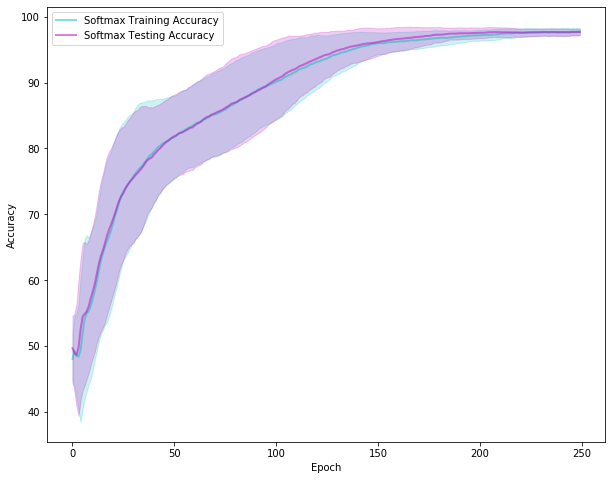

In [836]:
plot_acc(histories, 2, 'Tanh', train_history = True, test_history = True)
plot_acc(histories, 3, 'Softmax', train_history = True, test_history = True)

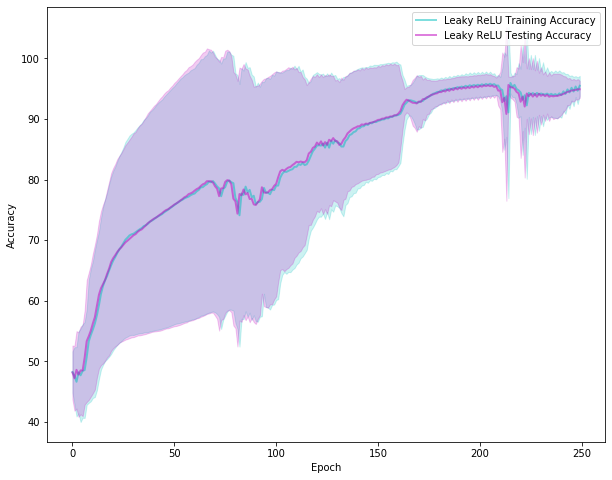

In [837]:
plot_acc(histories, 4, 'Leaky ReLU', train_history = True, test_history = True)